## Learning objectives

By the end of this lesson, you will be able to:

* Apply transformations to make target variable more normally distributed for Regression
* Apply inverse transformations to be able to use these in a Regression context


In [37]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [38]:
# Download data

# !wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/data/boston_housing_clean.pickle"

### Loading the Boston Housing Data


1. Cargamos los datos que estan en formato pickle rb= lectura binaria ya que los archivos pickle son de este estilo.

In [39]:

with open('boston_housing_clean.pickle', 'rb') as to_read:
    boston = pd.read_pickle(to_read)
boston_data = boston['dataframe']
boston_description = boston['description']

boston_data.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Determining Normality


1. Target variable (y) -> Distribución normal
- Visual approach
- test estadístico
2. Métodos para transformar a una D. normal
- Log transformation
- Square root transformation
- Box cox transformation
3. Test estadistico -> p-value > 0.05 para que sea una distribución normal.

### Using a Visual approach - Plotting a histogram:



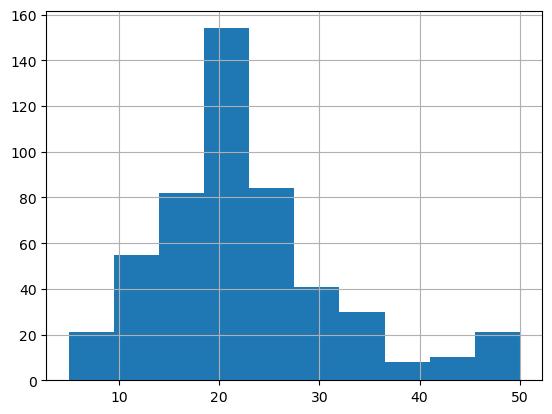

In [40]:
boston_data.MEDV.hist();

The histogram does not look normal due to its right tail.


#### Using a Statistical Test


In [41]:
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test

In [42]:
normaltest(boston_data.MEDV.values)

NormaltestResult(statistic=np.float64(90.9746873700967), pvalue=np.float64(1.7583188871696095e-20))

p-value is _extremely_ low. Our **y** variable which we have been dealing with this whole time was not normally distributed!


### Apply transformations to make target variable more normally distributed for Regression

**Log Transformation**

In [43]:
#Log method 
log_medv = np.log(boston_data.MEDV)

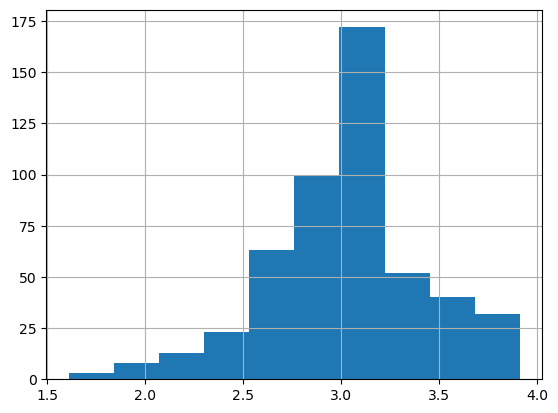

In [44]:
log_medv.hist()
plt.show()

In [45]:
normaltest(log_medv)

NormaltestResult(statistic=np.float64(17.21801696640698), pvalue=np.float64(0.00018245472768345196))

Conclusion: The output is closer to normal distribution, but still not completely normal.

**Square root Transformation**

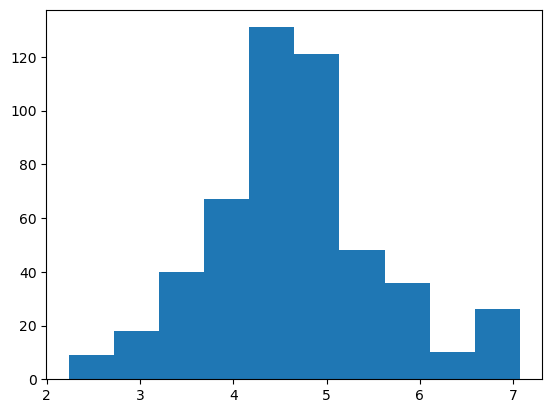

In [46]:
sqrt_medv = np.sqrt(boston_data.MEDV)
plt.hist(sqrt_medv)
plt.show()

In [47]:
normaltest(sqrt_medv)

NormaltestResult(statistic=np.float64(20.487090826863067), pvalue=np.float64(3.558645701429252e-05))

**Box cox Transformation**

In [48]:
from scipy.stats import boxcox

In [49]:
bc_result = boxcox(boston_data.MEDV)
boxcox_medv = bc_result[0]
lam = bc_result[1]

lam

np.float64(0.21662091371265346)

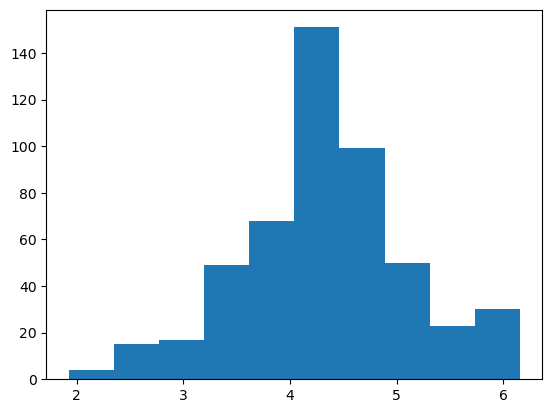

In [50]:
plt.hist(boxcox_medv)
plt.show()

In [51]:
normaltest(boxcox_medv)

NormaltestResult(statistic=np.float64(4.513528737272365), pvalue=np.float64(0.10468867128449004))

We find that the box cox results in a graph which is significantly more normally distributed (according to p value) than the other two distributions.This can be even above 0.05.

### Testing regression:

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures)

In [53]:
lr = LinearRegression()

**Define and load the predictor (X) and Target(y) variables**

In [54]:
y_col = "MEDV"

X = boston_data.drop(y_col, axis=1)
y = boston_data[y_col]

**Create Polynomial Features -> para mejorar la regresión lineal**

In [55]:
pf = PolynomialFeatures(degree=2, include_bias=False)
X_pf = pf.fit_transform(X)

**Split the data into Training and Test Sets**

The split ratio here is 0.7 and 0.3 which means we will assign 70% data for training and 30% data for testing

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.3, 
                                                    random_state=72018)

**Normalize the training data using StandardScaler on X_train. Use fit_transform() function**

In [57]:
s = StandardScaler()
X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)

### Fit Regression

In [59]:
lr.fit(X_train_s, y_train)

# predict 

lr_pred = lr.predict(X_test_s)
r_lineal = r2_score(y_test, lr_pred)
r_lineal

0.8689110469230994

**Applying inverse transformation boxcox on target variable (y)**

In [60]:
bc_result2 = boxcox(y_train)
y_train_bc = bc_result2[0]
lam2 = bc_result2[1]

y_train.shape

(354,)

Fit X_train_s and y_train_bc and then predict_bc

In [61]:
lr.fit(X_train_s, y_train_bc)
y_pred_bc = lr.predict(X_test_s)

Apply inverse transformations to be able to use these in a Regression context

In [62]:
from scipy.special import inv_boxcox

In [66]:
inv_boxcox(boxcox_medv, lam)[:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

In [67]:
boston_data['MEDV'].values[:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

Exactly the same, as we would hope!

Hint: Use the inv_boxcox() function to get the transformed predicted values

In [68]:
y_pred_tran = inv_boxcox(y_pred_bc, lam2)
r_lineal_boxcox = r2_score(y_test, y_pred_tran)
r_lineal_boxcox

0.8884878249151454

In [69]:
results = {
    'Regresion lineal': r_lineal,
    'Regresion lineal Box-cox': r_lineal_boxcox
}

df_comp = pd.DataFrame(results, index=['R²_score'])
df_comp

,Regresion lineal,Regresion lineal Box-cox
R²_score,0.868911,0.888488
